In [1]:
# ===========================================
# 📊 DATA ANALYSIS SCRIPT FOR JHU CROWD DATASET
# ===========================================

import os
import cv2
import yaml
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from matplotlib.patches import Rectangle

In [10]:
# ============================
# 1️⃣ Load Dataset YAML
# ============================

yaml_path = './data.yaml'

with open(yaml_path, 'r') as f:
    data_cfg = yaml.safe_load(f)

train_dir = data_cfg['train'].replace('..', './dataset')
val_dir = data_cfg['val'].replace('..', './dataset')
test_dir = data_cfg['test'].replace('..', './dataset')
names = data_cfg['names']
num_classes = data_cfg['nc']

print("Train Path:", train_dir)
print("Validation Path:", val_dir)
print("Test Path:", test_dir)
print("Classes:", names)

Train Path: ./train/images
Validation Path: ./valid/images
Test Path: ./test/images
Classes: ['head']


In [11]:
# ============================
# 2️⃣ Helper Functions
# ============================

def get_image_label_pairs(base_dir):
    img_dir = os.path.join(base_dir)
    lbl_dir = img_dir.replace("images", "labels")
    img_files = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png"))
    pairs = []
    for img_path in img_files:
        lbl_path = os.path.join(lbl_dir, os.path.basename(img_path).replace('.jpg', '.txt').replace('.png', '.txt'))
        if os.path.exists(lbl_path):
            pairs.append((img_path, lbl_path))
    return pairs

def load_labels(lbl_path):
    try:
        with open(lbl_path, 'r') as f:
            boxes = [list(map(float, line.strip().split())) for line in f.readlines()]
        return np.array(boxes)
    except:
        return np.array([])

In [12]:
# ============================
# 3️⃣ Collect All Data Pairs
# ============================

splits = {
    'train': get_image_label_pairs(train_dir),
    'val': get_image_label_pairs(val_dir),
    'test': get_image_label_pairs(test_dir)
}

for k, v in splits.items():
    print(f"{k.upper()} → {len(v)} image-label pairs")

TRAIN → 2263 image-label pairs
VAL → 497 image-label pairs
TEST → 1600 image-label pairs


In [13]:
# ============================
# 4️⃣ Image–Label Correspondence Check
# ============================

missing_labels = {k: [i for i, l in v if not os.path.exists(l.replace('images', 'labels'))] for k, v in splits.items()}
for k, v in missing_labels.items():
    print(f"{k.upper()} missing label files: {len(v)}")

TRAIN missing label files: 0
VAL missing label files: 0
TEST missing label files: 0


In [14]:
# ============================
# 5️⃣ Bounding Box Statistics
# ============================

bbox_widths, bbox_heights = [], []
object_counts = []

for split, pairs in splits.items():
    for img_path, lbl_path in tqdm(pairs, desc=f"Processing {split}"):
        boxes = load_labels(lbl_path)
        if boxes.size > 0:
            bbox_widths.extend(boxes[:,3])
            bbox_heights.extend(boxes[:,4])
            object_counts.append(len(boxes))

Processing test: 100%|██████████| 1600/1600 [00:01<00:00, 1492.37it/s]


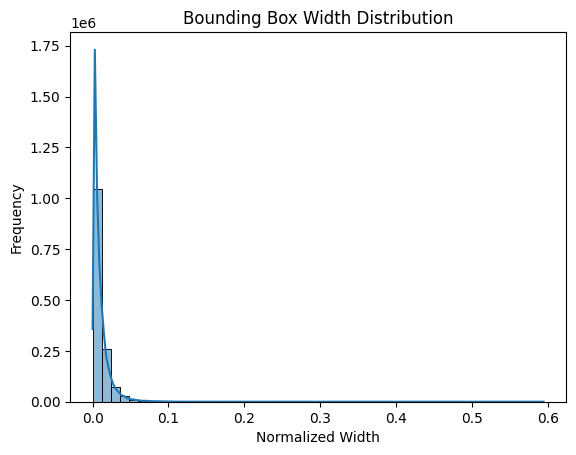

In [15]:
# Plot bounding box stats
plt.figure()
sns.histplot(bbox_widths, bins=50, kde=True)
plt.title("Bounding Box Width Distribution")
plt.xlabel("Normalized Width")
plt.ylabel("Frequency")
plt.show()

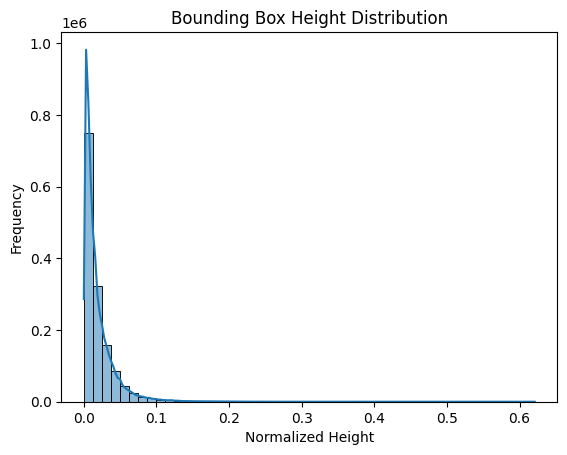

In [16]:
plt.figure()
sns.histplot(bbox_heights, bins=50, kde=True)
plt.title("Bounding Box Height Distribution")
plt.xlabel("Normalized Height")
plt.ylabel("Frequency")
plt.show()

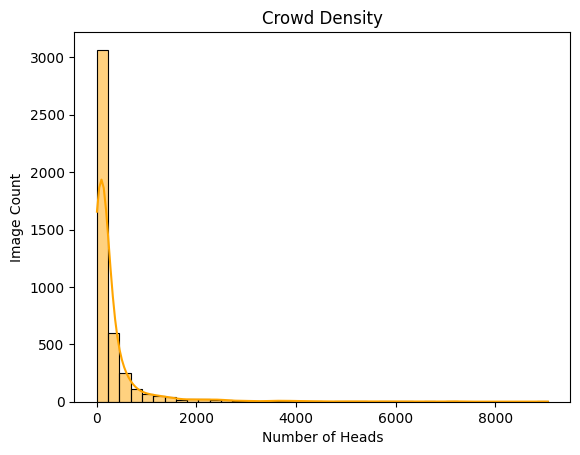

In [17]:
# ============================
# 6️⃣ Object Count Distribution (Crowd Density)
# ============================

plt.figure()
sns.histplot(object_counts, bins=40, color='orange', kde=True)
plt.title("Crowd Density")
plt.xlabel("Number of Heads")
plt.ylabel("Image Count")
plt.show()


In [18]:
# ============================
# 7️⃣ Sample Visualization (Image + Annotations)
# ============================

def visualize_sample(img_path, lbl_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    boxes = load_labels(lbl_path)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(img)
    if boxes.size > 0:
        for b in boxes:
            cls, x, y, bw, bh = b
            x1 = int((x - bw/2) * w)
            y1 = int((y - bh/2) * h)
            x2 = int((x + bw/2) * w)
            y2 = int((y + bh/2) * h)
            rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1.5, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-5, names[int(cls)], color='yellow', fontsize=8, backgroundcolor='black')
    ax.set_title("Sample Image with Bounding Boxes")
    plt.axis('off')
    plt.show()

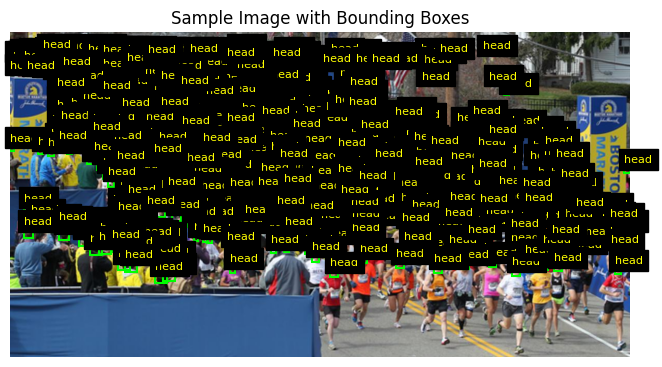

In [19]:
sample_img, sample_lbl = splits['train'][1]
visualize_sample(sample_img, sample_lbl)

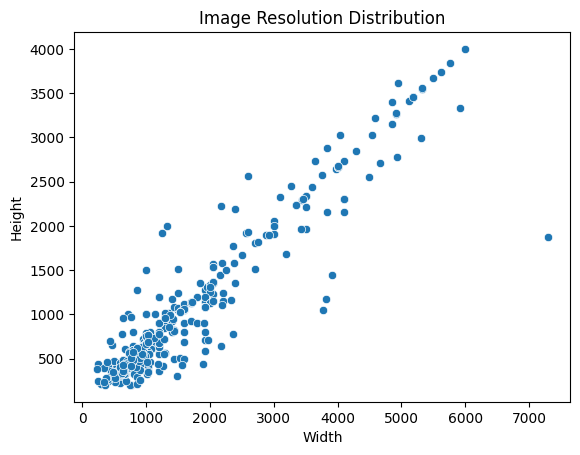

In [20]:
# ============================
# 8️⃣ Image Resolution Analysis
# ============================

resolutions = []
for split, pairs in splits.items():
    for img_path, _ in pairs[:200]:
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            resolutions.append((w, h))

resolutions = np.array(resolutions)
plt.figure()
sns.scatterplot(x=resolutions[:,0], y=resolutions[:,1])
plt.title("Image Resolution Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [21]:
# ============================
# 9️⃣ Split Comparison Summary
# ============================

summary = {}
for split, pairs in splits.items():
    total_imgs = len(pairs)
    total_objs = sum([len(load_labels(lbl)) for _, lbl in pairs])
    summary[split] = {'images': total_imgs, 'objects': total_objs, 'avg_objects_per_image': total_objs/total_imgs if total_imgs else 0}

print("=== Dataset Summary ===")
for k,v in summary.items():
    print(f"{k.upper()} → Images: {v['images']}, Objects: {v['objects']}, Avg objs/img: {v['avg_objects_per_image']:.2f}")

=== Dataset Summary ===
TRAIN → Images: 2263, Objects: 761969, Avg objs/img: 336.71
VAL → Images: 497, Objects: 145461, Avg objs/img: 292.68
TEST → Images: 1600, Objects: 516344, Avg objs/img: 322.71


<Figure size 640x480 with 0 Axes>

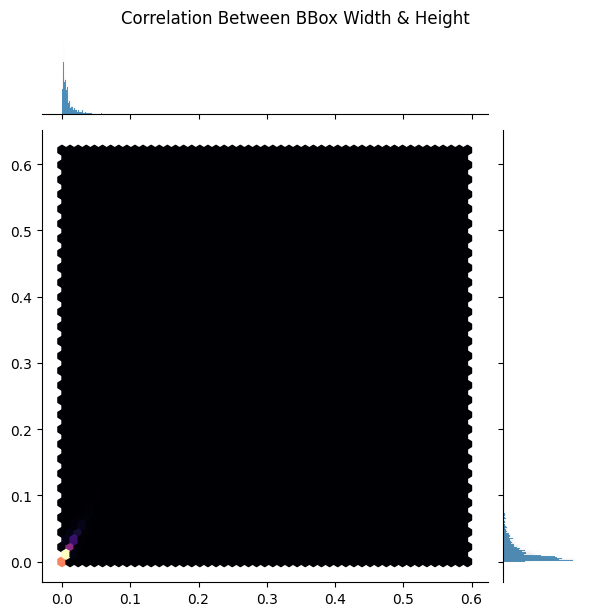

In [22]:
# ============================
# 🔟 Correlation Insights (Optional)
# ============================

plt.figure()
sns.jointplot(x=bbox_widths, y=bbox_heights, kind='hex', cmap='magma')
plt.suptitle("Correlation Between BBox Width & Height", y=1.02)
plt.show()

In [23]:
# ============================
# 1️⃣1️⃣ (Bonus) Annotation Heatmap Overlay — FIXED VERSION
# ============================

from scipy.ndimage import gaussian_filter

def generate_heatmap(pairs, size=(640,480), sigma=5):
    """
    Generates a heatmap of annotation density from YOLO labels.
    size: (width, height)
    sigma: blur intensity for smoother visualization
    """
    heatmap = np.zeros((size[1], size[0]))  # (height, width)
    for img_path, lbl_path in tqdm(pairs[:300], desc="Generating heatmap"):
        boxes = load_labels(lbl_path)
        if boxes.size > 0:
            for _, x, y, _, _ in boxes:
                # Clip normalized coordinates to [0,1]
                x = np.clip(x, 0, 1)
                y = np.clip(y, 0, 1)
                px, py = int(x * (size[0]-1)), int(y * (size[1]-1))
                heatmap[py, px] += 1

    # Smooth the heatmap for better visualization
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap

Generating heatmap: 100%|██████████| 300/300 [00:00<00:00, 359.16it/s]


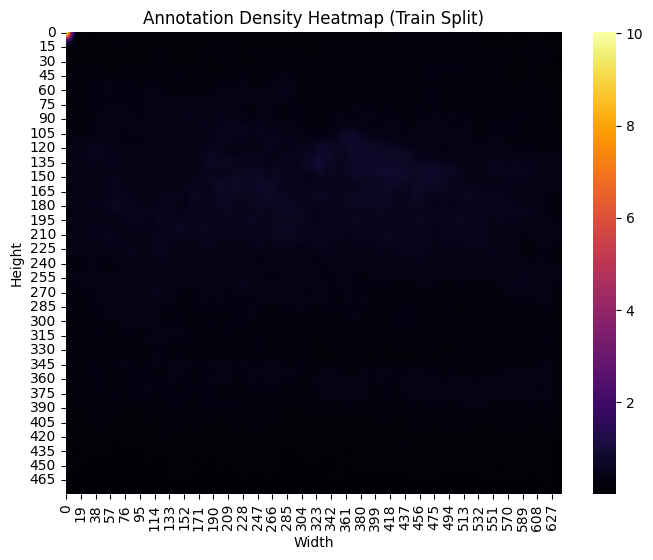

In [24]:
# Generate and plot heatmap
heatmap = generate_heatmap(splits['train'])
plt.figure(figsize=(8,6))
sns.heatmap(heatmap, cmap='inferno')
plt.title("Annotation Density Heatmap (Train Split)")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

Generating heatmap: 100%|██████████| 300/300 [00:00<00:00, 359.07it/s]


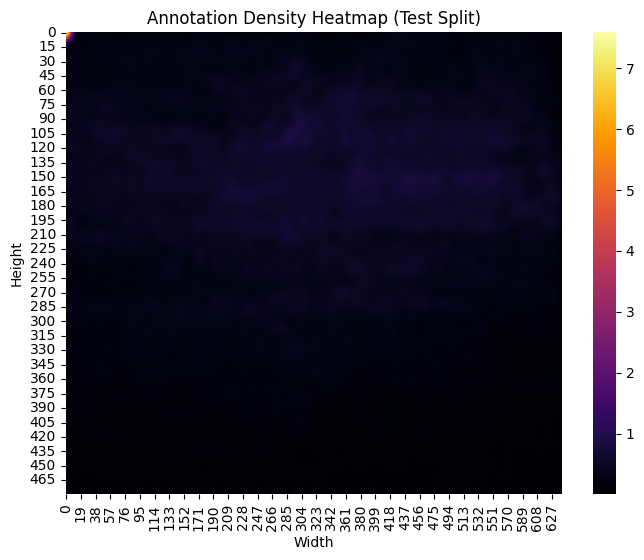

In [25]:
# Generate and plot heatmap
heatmap = generate_heatmap(splits['test'])
plt.figure(figsize=(8,6))
sns.heatmap(heatmap, cmap='inferno')
plt.title("Annotation Density Heatmap (Test Split)")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

Generating heatmap: 100%|██████████| 300/300 [00:00<00:00, 329.40it/s]


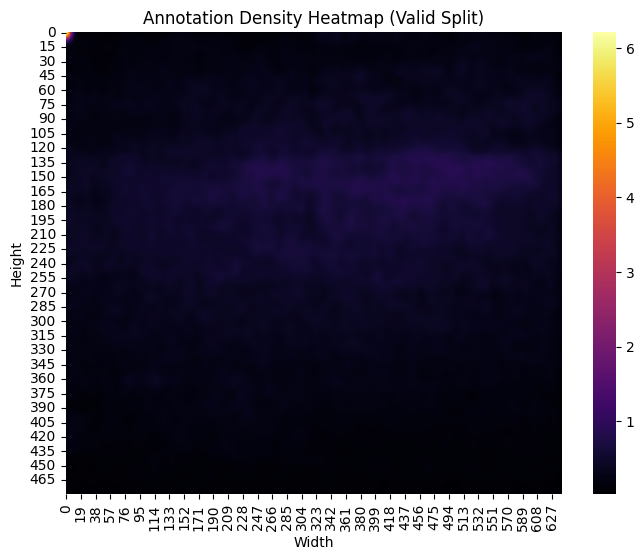

In [26]:
# Generate and plot heatmap
heatmap = generate_heatmap(splits['val'])
plt.figure(figsize=(8,6))
sns.heatmap(heatmap, cmap='inferno')
plt.title("Annotation Density Heatmap (Valid Split)")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [27]:
# ============================
# 1️⃣2️⃣ Summary Dashboard
# ============================

print("\n📊 === SUMMARY DASHBOARD ===")
print(f"Classes: {names}")
print(f"Train Images: {summary['train']['images']}")
print(f"Validation Images: {summary['val']['images']}")
print(f"Test Images: {summary['test']['images']}")
print(f"Average Objects/Image (Train): {summary['train']['avg_objects_per_image']:.2f}")
print(f"Total Bounding Boxes (All Splits): {sum(v['objects'] for v in summary.values())}")
print("✅ Data analysis completed successfully!")


📊 === SUMMARY DASHBOARD ===
Classes: ['head']
Train Images: 2263
Validation Images: 497
Test Images: 1600
Average Objects/Image (Train): 336.71
Total Bounding Boxes (All Splits): 1423774
✅ Data analysis completed successfully!


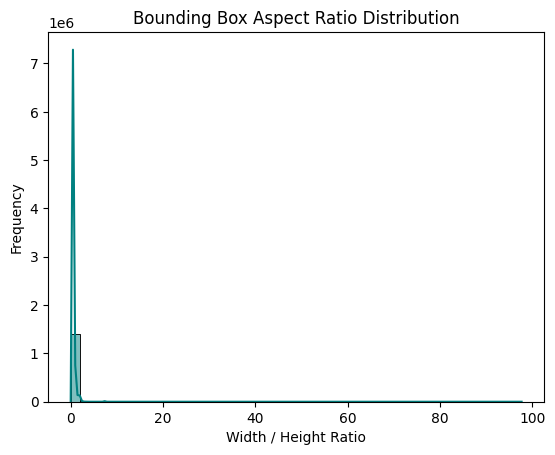

In [28]:
ratios = np.array(bbox_widths) / np.array(bbox_heights)
plt.figure()
sns.histplot(ratios, bins=50, color='teal', kde=True)
plt.title("Bounding Box Aspect Ratio Distribution")
plt.xlabel("Width / Height Ratio")
plt.ylabel("Frequency")
plt.show()

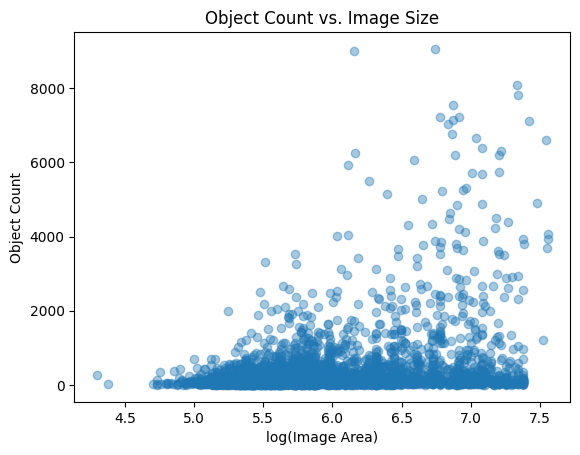

In [29]:
areas, counts = [], []
for split, pairs in splits.items():
    for img_path, lbl_path in pairs:
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            boxes = load_labels(lbl_path)
            areas.append(w*h)
            counts.append(len(boxes))

plt.scatter(np.log10(areas), counts, alpha=0.4)
plt.title("Object Count vs. Image Size")
plt.xlabel("log(Image Area)")
plt.ylabel("Object Count")
plt.show()

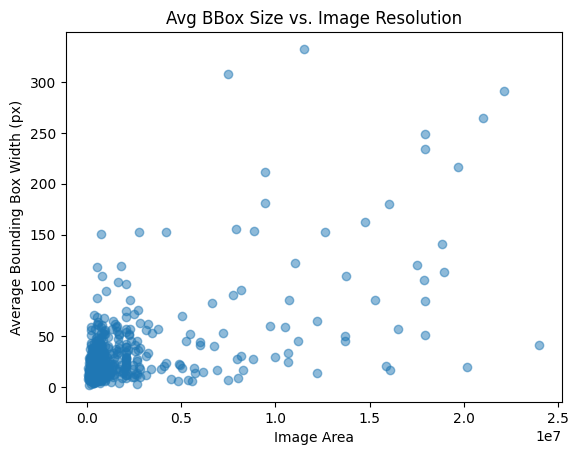

In [30]:
avg_bbox_sizes, img_resolutions = [], []
for split, pairs in splits.items():
    for img_path, lbl_path in pairs[:200]:
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            boxes = load_labels(lbl_path)
            if boxes.size > 0:
                avg_bbox = np.mean(boxes[:,3]*w)
                avg_bbox_sizes.append(avg_bbox)
                img_resolutions.append(w*h)

plt.scatter(img_resolutions, avg_bbox_sizes, alpha=0.5)
plt.title("Avg BBox Size vs. Image Resolution")
plt.xlabel("Image Area")
plt.ylabel("Average Bounding Box Width (px)")
plt.show()

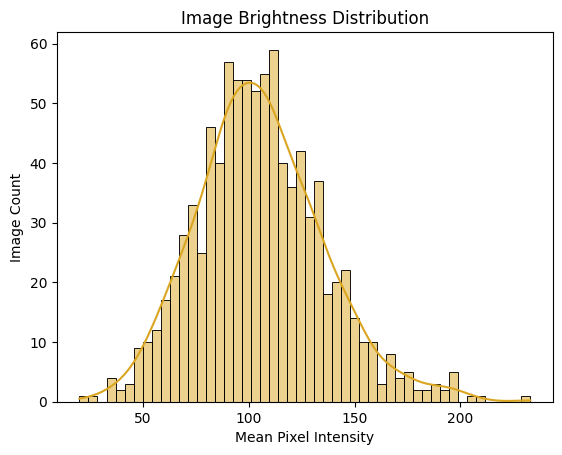

In [31]:
brightness = []
for split, pairs in splits.items():
    for img_path, _ in pairs[:300]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            brightness.append(img.mean())

sns.histplot(brightness, bins=50, color='goldenrod', kde=True)
plt.title("Image Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Image Count")
plt.show()

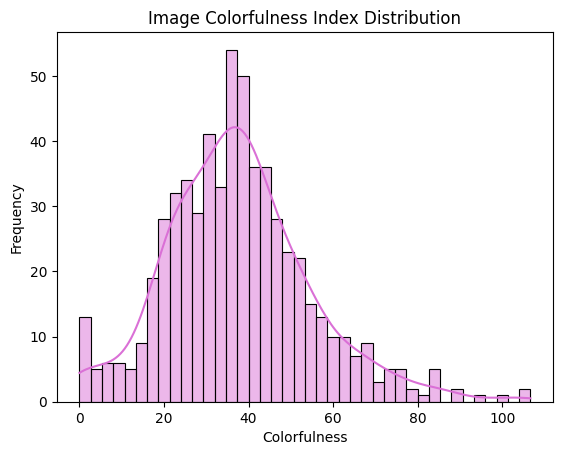

In [32]:
def colorfulness(img):
    (B, G, R) = cv2.split(img.astype("float"))
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    std_rg, std_yb = np.std(rg), np.std(yb)
    mean_rg, mean_yb = np.mean(rg), np.mean(yb)
    return np.sqrt(std_rg**2 + std_yb**2) + (0.3 * np.sqrt(mean_rg**2 + mean_yb**2))

color_values = []
for split, pairs in splits.items():
    for img_path, _ in pairs[:200]:
        img = cv2.imread(img_path)
        if img is not None:
            color_values.append(colorfulness(img))

sns.histplot(color_values, bins=40, color='orchid', kde=True)
plt.title("Image Colorfulness Index Distribution")
plt.xlabel("Colorfulness")
plt.ylabel("Frequency")
plt.show()

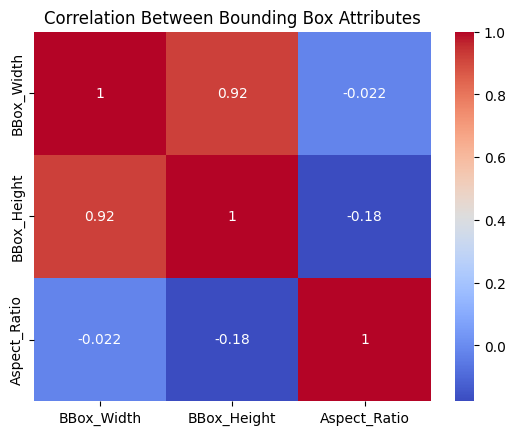

In [33]:
import pandas as pd

df_summary = pd.DataFrame({
    "BBox_Width": bbox_widths,
    "BBox_Height": bbox_heights,
    "Aspect_Ratio": np.array(bbox_widths)/np.array(bbox_heights)
})
sns.heatmap(df_summary.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Bounding Box Attributes")
plt.show()